In [7]:
# Investigation an issue related CI-test in PC algorithm.

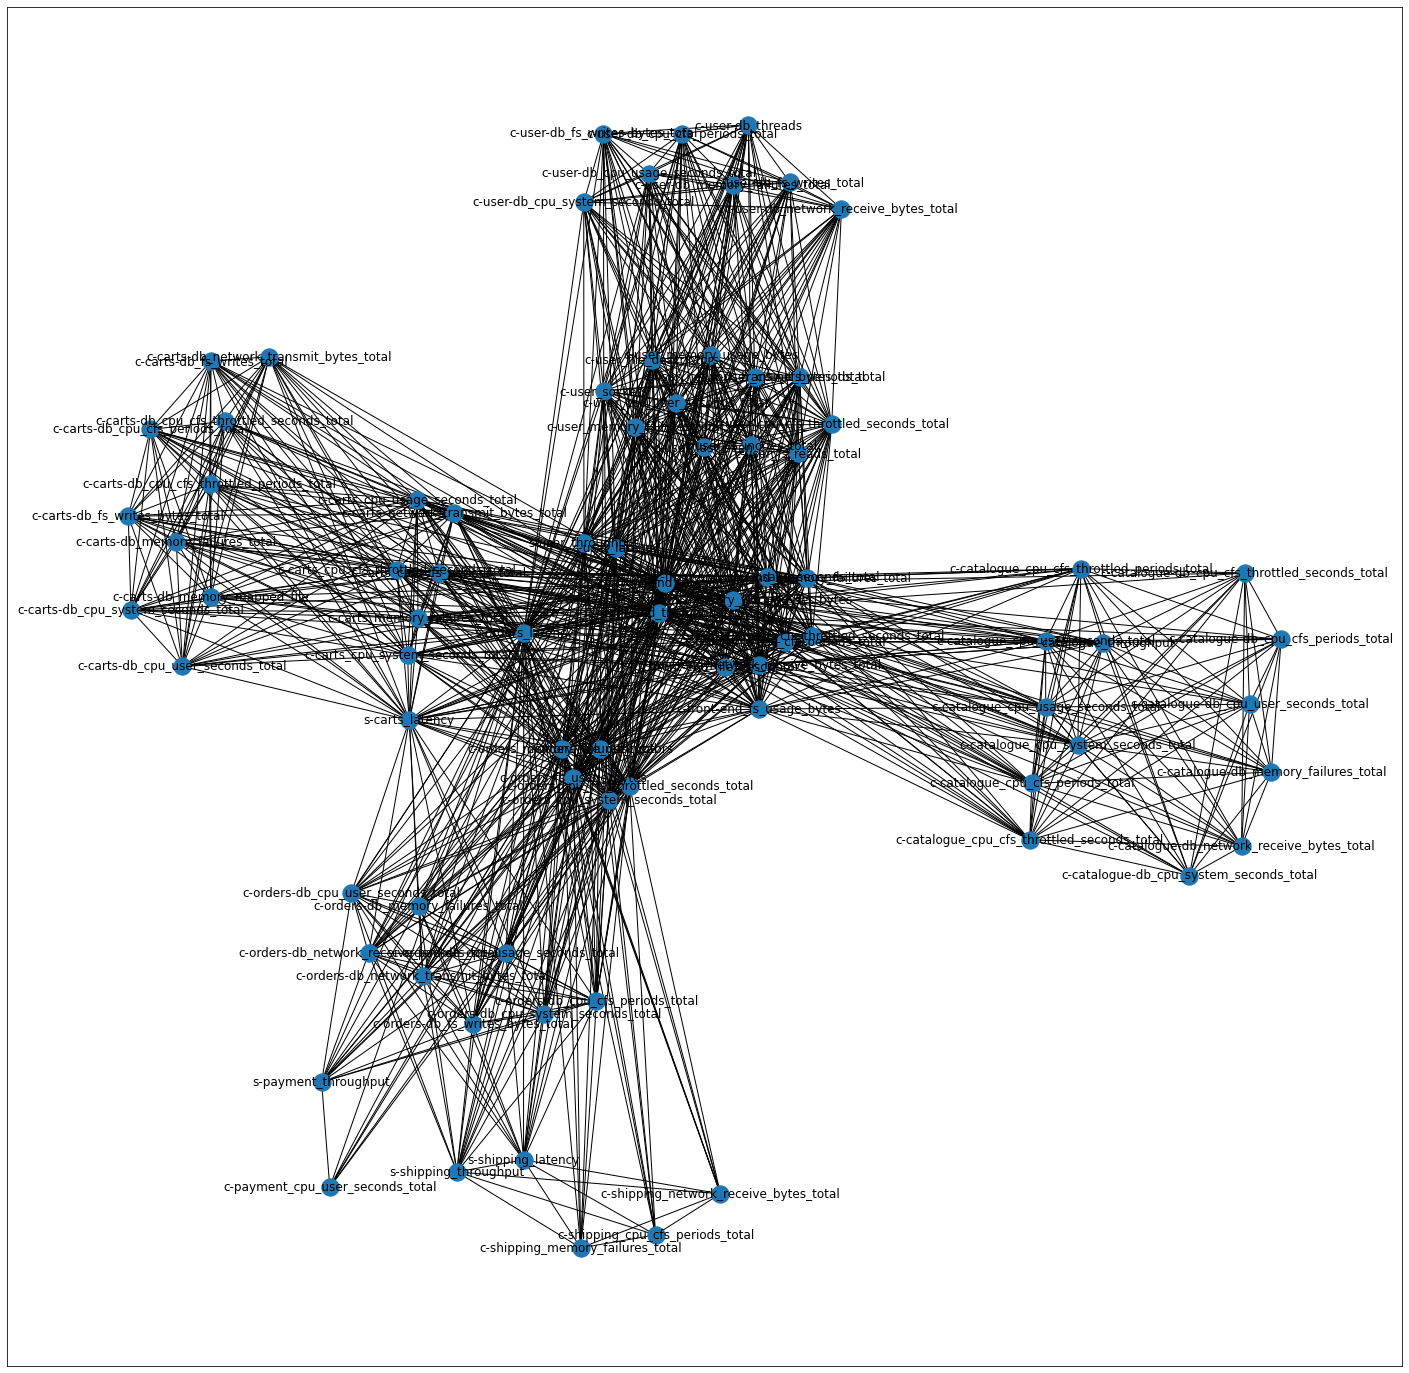

In [8]:
from multiprocessing import cpu_count
import sys
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append('../')
from tsdr import tsdr
from diagnoser import diag
from diagnoser.diag import prepare_init_graph, filter_by_target_metrics
from meltria import loader
import diagnoser.metric_node as mn
import eval.priorknowledge as pk

filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_1.json'
data_df, mappings = loader.read_metrics_file(filepath)

reducer = tsdr.Tsdr(tsdr.ar_based_ad_model, **{
    'tsifter_step1_ar_regression': 'n',
    'tsifter_step1_ar_anomaly_score_threshold': 0.01,
    'tsifter_step1_cv_threshold': 0.05,
    'tsifter_step1_ar_dynamic_prediction': False,
    'tsifter_step2_clustering_threshold': 0.01,
    'tsifter_step2_clustered_series_type': 'raw',
    'tsifter_step2_clustering_dist_type': 'sbd',
    'tsifter_step2_clustering_choice_method': 'medoid',
    'tsifter_step2_clustering_linkage_method': 'single',
})
_, reduced_df_by_step, metrics_dimension, _ = reducer.run(
    series=data_df,
    max_workers=cpu_count(),
)
reduced_df = reduced_df_by_step['step2']

dataset = filter_by_target_metrics(reduced_df)
nodes: mn.MetricNodes = mn.MetricNodes.from_dataframe(dataset)
init_g: nx.Graph = prepare_init_graph(nodes, mappings)
fig = plt.figure(1, figsize=(25, 25))
nx.draw_networkx(init_g, node_size=300, pos=nx.spring_layout(init_g))

False []
DiGraph with 43 nodes and 59 edges


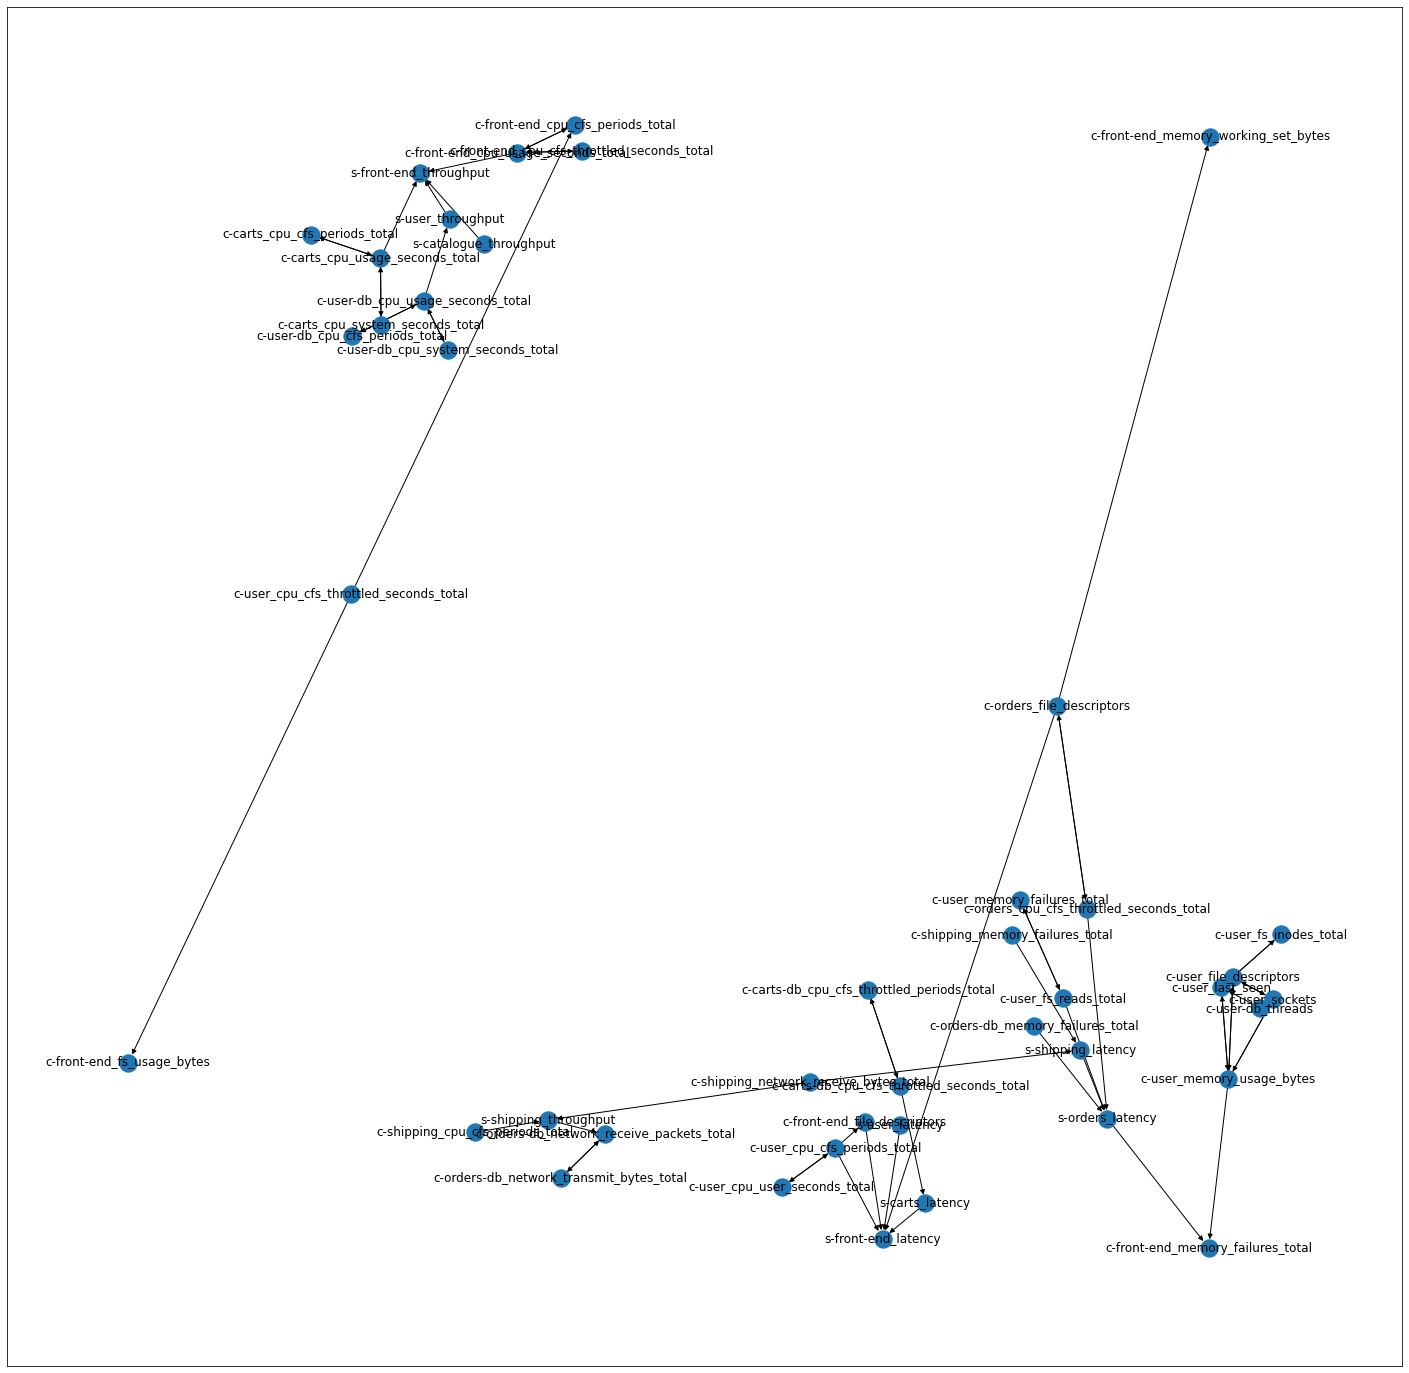

In [9]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pcalg
from diagnoser.citest.fisher_z import ci_test_fisher_z
from diagnoser.citest.pearsonr import ci_test_pearsonr
from eval import groundtruth
from gsq.ci_tests import ci_test_bin, ci_test_dis

relabeled_init_g = nx.relabel_nodes(init_g, mapping=nodes.node_to_num)
dm = dataset.to_numpy()
cm = np.corrcoef(dm.T)
(G, sep_set) = pcalg.estimate_skeleton(
    indep_test_func=ci_test_pearsonr,
    data_matrix=dm,
    alpha=0.05,
    corr_matrix=cm,
    init_graph=relabeled_init_g,
    method='stable',
    max_reach=2,
    node_id_to_metric_node=nodes.num_to_node,
)
DG: nx.DiGraph = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
DG = nx.relabel_nodes(DG, mapping=nodes.num_to_node)
DG = diag.fix_edge_directions_in_causal_graph(DG)
DG = diag.remove_nodes_subgraph_uncontained_root(DG)
graph_ok, routes = groundtruth.check_causal_graph(DG, 'pod-memory-hog', 'user')
print(graph_ok, routes)
fig = plt.figure(1, figsize=(25, 25))
nx.draw_networkx(DG, node_size=300, pos=nx.spring_layout(DG))
print(DG)

s-user_latency ShapiroResult(statistic=0.5426911115646362, pvalue=1.1413606009671024e-17)
s-front-end_latency ShapiroResult(statistic=0.3830738663673401, pvalue=2.868456861650469e-20)
c-user_memory_usage_bytes ShapiroResult(statistic=0.46083366870880127, pvalue=4.481629920624153e-19)
c-orders-db_network_transmit_bytes_total ShapiroResult(statistic=0.906829833984375, pvalue=4.4599261173061677e-07)


,citest_method,x,y,z,coeff,p_val,acceptance
0,fisher_z,s-front-end_latency,c-user_memory_usage_bytes,None,13.160064,1.489598e-39,False
1,fisher_z,s-front-end_latency,c-user_memory_usage_bytes,s-user_latency,9.068442,1.207310e-19,False
2,pearsonr,s-front-end_latency,c-user_memory_usage_bytes,None,0.838663,6.337973e-33,False
3,pearsonr,s-front-end_latency,c-user_memory_usage_bytes,s-user_latency,0.686858,4.683790e-18,False
4,fisher_z,s-user_latency,c-user_memory_usage_bytes,None,8.667045,4.434800e-18,False
5,fisher_z,s-user_latency,c-user_memory_usage_bytes,s-front-end_latency,-0.848831,3.959754e-01,True
6,pearsonr,s-user_latency,c-user_memory_usage_bytes,None,0.664745,1.243362e-16,False
7,pearsonr,s-user_latency,c-user_memory_usage_bytes,s-front-end_latency,-0.078649,3.931800e-01,True
8,fisher_z,s-user_latency,s-front-end_latency,None,12.570358,3.073302e-36,False
9,fisher_z,s-user_latency,s-front-end_latency,c-user_memory_usage_bytes,8.339024,7.490612e-17,False


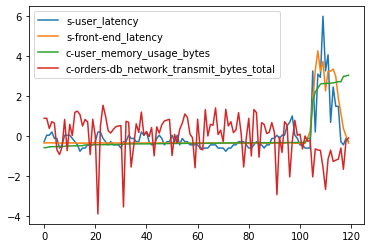

In [21]:
from itertools import product, combinations
import pandas as pd
from scipy import stats

from diagnoser.citest.fisher_z_pgmpy import fisher_z
from pgmpy.estimators.CITests import chi_square, pearsonr


vars = ('s-user_latency', 's-front-end_latency', 'c-user_memory_usage_bytes', 'c-orders-db_network_transmit_bytes_total')
small_df = dataset[list(vars)]
small_df.plot()
alpha = 0.05

# test a test of normality.
for var in vars:
    print(var, stats.shapiro(small_df[var]))

scores = []
for vars3 in combinations(vars, 3):
    for z, citest_func in product(vars3, (fisher_z, pearsonr)):
        x, y = tuple(set(vars3) - {z})
        coeff, p_val = citest_func(x, y, [], dataset, boolean=False)
        scores.append([citest_func.__name__, x, y, None, coeff, p_val, p_val >= alpha])
        coeff, p_val = citest_func(x, y, [z], dataset, boolean=False)
        scores.append([citest_func.__name__, x, y, z, coeff, p_val, p_val >= alpha])
pd.DataFrame(scores, columns=['citest_method', 'x', 'y', 'z', 'coeff', 'p_val', 'acceptance'])

In [18]:
from diagnoser.citest.fisher_z import ci_test_fisher_z
from diagnoser.citest.pearsonr import ci_test_pearsonr

dm = dataset[list(vars)].to_numpy()
cm = np.corrcoef(dm.T)
label_to_num = {v: i for i, v in enumerate(vars)}
num_to_label = {i: v for i, v in enumerate(vars)}
scores = []
for vars3 in combinations(vars, 3):
    for z, citest_func in product(vars3, (ci_test_fisher_z, ci_test_pearsonr)):
        x, y = tuple(set(vars3) - {z})
        X, Y, Z = label_to_num[x], label_to_num[y], label_to_num[z]
        p_val = citest_func(dm, X, Y, [], corr_matrix=cm)
        scores.append([citest_func.__name__, x, y, None, np.NaN, p_val, p_val >= alpha])
        p_val = citest_func(dm, X, Y, [Z], corr_matrix=cm)
        scores.append([citest_func.__name__, x, y, z, np.NaN, p_val, p_val >= alpha])
pd.DataFrame(scores, columns=['citest_method', 'x', 'y', 'z', 'coeff', 'p_val', 'acceptance'])

,citest_method,x,y,z,coeff,p_val,acceptance
0,ci_test_fisher_z,s-front-end_latency,c-user_memory_usage_bytes,None,NaN,1.489598e-39,False
1,ci_test_fisher_z,s-front-end_latency,c-user_memory_usage_bytes,s-user_latency,NaN,1.207310e-19,False
2,ci_test_pearsonr,s-front-end_latency,c-user_memory_usage_bytes,None,NaN,6.337973e-33,False
3,ci_test_pearsonr,s-front-end_latency,c-user_memory_usage_bytes,s-user_latency,NaN,4.683790e-18,False
4,ci_test_fisher_z,s-user_latency,c-user_memory_usage_bytes,None,NaN,4.434800e-18,False
5,ci_test_fisher_z,s-user_latency,c-user_memory_usage_bytes,s-front-end_latency,NaN,3.959754e-01,True
6,ci_test_pearsonr,s-user_latency,c-user_memory_usage_bytes,None,NaN,1.243362e-16,False
7,ci_test_pearsonr,s-user_latency,c-user_memory_usage_bytes,s-front-end_latency,NaN,3.931800e-01,True
8,ci_test_fisher_z,s-user_latency,s-front-end_latency,None,NaN,3.073302e-36,False
9,ci_test_fisher_z,s-user_latency,s-front-end_latency,c-user_memory_usage_bytes,NaN,7.490612e-17,False


DiGraph with 4 nodes and 6 edges


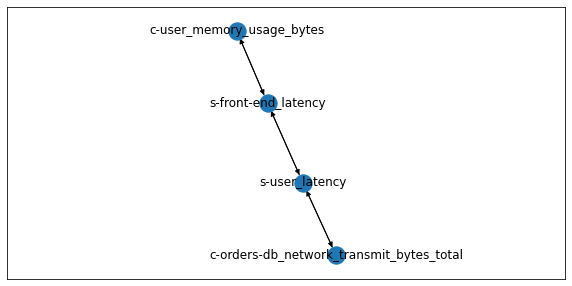

In [20]:
(G, sep_set) = pcalg.estimate_skeleton(
    indep_test_func=ci_test_pearsonr,
    data_matrix=dm,
    alpha=0.05,
    corr_matrix=cm,
    method='stable',
)
DG: nx.DiGraph = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
DG = nx.relabel_nodes(DG, mapping=num_to_label)
fig = plt.figure(1, figsize=(10, 5))
nx.draw_networkx(DG, node_size=300, pos=nx.spring_layout(DG))
print(DG)

In [13]:
from diagnoser.citest.fisher_z_pgmpy import fisher_z
from pgmpy import estimators
from diagnoser.PC import PC

relabeled_init_label_g = mn.relabel_graph_nodes_to_label(init_g)
c = PC(data=dataset)
G = c.build_skeleton(
    init_graph=relabeled_init_label_g,
    variant='stable',
    ci_test='pearsonr',
    significance_level=0.05,
    return_type='pdag',
)
# DG: nx.DiGraph = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)
# DG = nx.relabel_nodes(G, mapping=nodes.num_to_node)
print(DG)
DG = diag.fix_edge_directions_in_causal_graph(DG)
DG = diag.remove_nodes_subgraph_uncontained_root(DG)
graph_ok, routes = groundtruth.check_causal_graph(DG, 'pod-memory-hog', 'user')
print(graph_ok, routes)
fig = plt.figure(1, figsize=(25, 25))
nx.draw_networkx(DG, node_size=300, pos=nx.spring_layout(DG))

Working for n conditional variables: 5: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/notebooks/../diagnoser/PC.py:371: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

DiGraph with 3 nodes and 4 edges


AttributeError: 'str' object has no attribute 'is_service'